In [1]:
%matplotlib inline

In [6]:
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from math import sqrt
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
import time

def color(i,j):
    delta=i/j
    return (delta,delta,delta)

def plotImportantFeatures(matrix):
    matrixFeaturesImportances=[] 
    x = []
    n=0
    fig = plt.figure(num=2, figsize=(20,10))
    for i in matrix :
        matrixFeaturesImportances.append(i.feature_importances_.tolist())
    nbFeatures =  len(matrixFeaturesImportances[0])
    #moyenne d'importance des features pour tous les classifieurs
    mean=[]
    sum=0
    for j in range(0,nbFeatures):
        sum=0
        for classifier in matrixFeaturesImportances :
            sum=sum + classifier[j]
        mean.append(sum/len(matrixFeaturesImportances))   
        
    for i in range(0,len(matrix)):
        e=[]
        for i in range(0,nbFeatures):
            n=n+1
            e.append(n)
        x.append(e)
    width = 0.125
    plt.subplot(211)
    plt.title('feature importances on every classifier')
    plt.xlabel('features')
    #transpose
    import numpy as np
    matrixFeaturesImportances = np.array(matrixFeaturesImportances).T.tolist()
    print("transposed")
    print(len(matrixFeaturesImportances))
    for i in range(0,len(matrixFeaturesImportances)):
        print("plting" + str(i))
        colori=color(i%nbFeatures,nbFeatures)
        plt.bar(i,matrixFeaturesImportances[i], width, color=colori)
    plt.subplot(212)
    x= range(0,nbFeatures)
    plt.bar(x,mean, 1, color='b')
    plt.title('means of feature importances on every classifier')
    plt.xlabel('features')
    plt.show()
   
def trainClassifier(folderPath,maxTurn):
    classifier=[]
    classifierImportantFeatures=[]
    nbrTurnMax = len(os.listdir(folderPath))
    dataset = np.loadtxt(folderPath+'/turn'+str(1)+'.txt', delimiter=",")
    nbFeatures=len(dataset[0])
    for i in range(0,min(maxTurn,nbrTurnMax-1)):
        dataset = np.loadtxt(folderPath+'/turn'+str(i+1)+'.txt', delimiter=",")
        X = dataset[:,1:]
        y = dataset[:,0]
        model = LogisticRegression()
   
        forest = ExtraTreesClassifier()
        model.fit(X, y)
        forest.fit(X,y)
        classifier.append(model)
        classifierImportantFeatures.append(forest)
  
    plotImportantFeatures(classifierImportantFeatures)
    return classifier

def testClassifier(listClassifier,folderPathTest,maxTurn):

    listTestGame = os.listdir(folderPathTest)
    nbGameTestMax =len(listTestGame)
    resA=[]
    resB=[]
    listClassifier_pred_y=[]
    listClassifier_test_y=[]
    game = np.loadtxt(folderPathTest+'/game'+str(1)+'.txt', delimiter=",")

    for i in range(1,nbGameTestMax+1):
        game = np.loadtxt(folderPathTest+'/game'+str(i)+'.txt', delimiter=",")
        resGameA=[]
        resGameB=[]
        for j in range(0,min(len(game),min(maxTurn,len(listClassifier)))):
            if len(listClassifier_pred_y)<min(len(game),min(maxTurn+1,len(listClassifier))):
                listClassifier_pred_y.append([])
                listClassifier_test_y.append([])
            gameCour=game[:,1:]
            proba = listClassifier[j].predict_proba(gameCour[j].reshape(1, -1))[0][1]
            y = listClassifier[j].predict(gameCour[j].reshape(1, -1))
            listClassifier_pred_y[j].append(y[0])
            listClassifier_test_y[j].append(game[0][0])
            if game[0][0] == 1: #if "Me" won
                resGameA.append(proba)
            else :
                resGameB.append(1-proba)
          
        if len(resGameA)!=0:
            resA.append(resGameA)
        if len(resGameB)!=0:
            resB.append(resGameB)
        
    return resA,resB,listClassifier_pred_y,listClassifier_test_y

def plotProbaMeans(matrixProbaA,matrixProbaB):
    fig = plt.figure(num=1, figsize=(10,10))
    subplots_adjust(wspace=3.0)
    meanA=[]
    meanB=[]
    matrixALength=len(matrixProbaA)
    matrixBLength=len(matrixProbaB)
    for i in range(0, matrixALength):
        sum=0
        nbGameWithiTurn=0
        for j in matrixProbaA:
             if(len(j)>i):
                sum = sum + j[i]
                nbGameWithiTurn=nbGameWithiTurn+1
        if  nbGameWithiTurn>0:
            meanA.append(sum/ nbGameWithiTurn)
    for i in range(0, matrixBLength):
        sum=0
        nbGameWithiTurn=0
        for j in matrixProbaB:
             
            if(len(j)>i):
                sum = sum + j[i]
                nbGameWithiTurn=nbGameWithiTurn+1
        if  nbGameWithiTurn>0:
            meanB.append(sum/nbGameWithiTurn)
    
    plt.subplot(221)
    plt.plot(meanA)
    plt.ylim(0,1)
    plt.ylabel('mean P of predicted Victory for Me and Me wins')
    plt.xlabel('turns')
    plt.subplot(222)
    plt.plot(meanB)
    plt.ylim(0,1)
    plt.ylabel('mean P of predicted Victory for Opp and Opp wins')
    plt.xlabel('turns')
    plt.show()
    
def plotProba(matrixProbaA,matrixProbaB):
    fig = plt.figure(num=1, figsize=(10,10))
    plt.subplots_adjust(wspace=3.0)
    
    for i in range(0,20):
        plt.subplot(221)
        plt.plot(matrixProbaA[i])
    for i in range (0,20):
        plt.subplot(222)
        plt.plot(matrixProbaB[i])
    plt.subplot(221)
    plt.ylim(0,1)
    plt.ylabel('P of predicted Victory for Me and Me wins')
    plt.xlabel('turns')
    plt.subplot(222)
    plt.ylim(0,1)
    plt.ylabel('P of predicted Victory for Opp and Opp wins')
    plt.xlabel('turns')
    plt.show()
      
def printScore(listClassifier_pred_y,listClassifier_test_y):
    for i in range(0,len(listClassifier_pred_y)):
        print('classifier : '+str(i+1))
        print('f1_score : '+str(f1_score(listClassifier_test_y[i],listClassifier_pred_y[i],average='binary')))
        print('MCC :'+str( matthews_corrcoef(listClassifier_test_y[i],listClassifier_pred_y[i]))+'\n')

c:\users\happymarky123\desktop\venvs\7333-venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\happymarky123\desktop\venvs\7333-venv\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\happymarky123\desktop\venvs\7333-venv\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\happymarky123\desktop\venvs\7333-venv\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\happymarky123\desktop\venvs\7

transposed
5650
plting0
plting1
plting2
plting3
plting4
plting5
plting6
plting7
plting8
plting9
plting10
plting11
plting12
plting13
plting14
plting15
plting16
plting17
plting18
plting19
plting20
plting21
plting22
plting23
plting24
plting25
plting26
plting27
plting28
plting29
plting30
plting31
plting32
plting33
plting34
plting35
plting36
plting37
plting38
plting39
plting40
plting41
plting42
plting43
plting44
plting45
plting46
plting47
plting48
plting49
plting50
plting51
plting52
plting53
plting54
plting55
plting56
plting57
plting58
plting59
plting60
plting61
plting62
plting63
plting64
plting65
plting66
plting67
plting68
plting69
plting70
plting71
plting72
plting73
plting74
plting75
plting76
plting77
plting78
plting79
plting80
plting81
plting82
plting83
plting84
plting85
plting86
plting87
plting88
plting89
plting90
plting91
plting92
plting93
plting94
plting95
plting96
plting97
plting98
plting99
plting100
plting101
plting102
plting103
plting104
plting105
plting106
plting107
plting108
plti

plting830
plting831
plting832
plting833
plting834
plting835
plting836
plting837
plting838
plting839
plting840
plting841
plting842
plting843
plting844
plting845
plting846
plting847
plting848
plting849
plting850
plting851
plting852
plting853
plting854
plting855
plting856
plting857
plting858
plting859
plting860
plting861
plting862
plting863
plting864
plting865
plting866
plting867
plting868
plting869
plting870
plting871
plting872
plting873
plting874
plting875
plting876
plting877
plting878
plting879
plting880
plting881
plting882
plting883
plting884
plting885
plting886
plting887
plting888
plting889
plting890
plting891
plting892
plting893
plting894
plting895
plting896
plting897
plting898
plting899
plting900
plting901
plting902
plting903
plting904
plting905
plting906
plting907
plting908
plting909
plting910
plting911
plting912
plting913
plting914
plting915
plting916
plting917
plting918
plting919
plting920
plting921
plting922
plting923
plting924
plting925
plting926
plting927
plting928
plting929


plting1591
plting1592
plting1593
plting1594
plting1595
plting1596
plting1597
plting1598
plting1599
plting1600
plting1601
plting1602
plting1603
plting1604
plting1605
plting1606
plting1607
plting1608
plting1609
plting1610
plting1611
plting1612
plting1613
plting1614
plting1615
plting1616
plting1617
plting1618
plting1619
plting1620
plting1621
plting1622
plting1623
plting1624
plting1625
plting1626
plting1627
plting1628
plting1629
plting1630
plting1631
plting1632
plting1633
plting1634
plting1635
plting1636
plting1637
plting1638
plting1639
plting1640
plting1641
plting1642
plting1643
plting1644
plting1645
plting1646
plting1647
plting1648
plting1649
plting1650
plting1651
plting1652
plting1653
plting1654
plting1655
plting1656
plting1657
plting1658
plting1659
plting1660
plting1661
plting1662
plting1663
plting1664
plting1665
plting1666
plting1667
plting1668
plting1669
plting1670
plting1671
plting1672
plting1673
plting1674
plting1675
plting1676
plting1677
plting1678
plting1679
plting1680
plting1681

plting2336
plting2337
plting2338
plting2339
plting2340
plting2341
plting2342
plting2343
plting2344
plting2345
plting2346
plting2347
plting2348
plting2349
plting2350
plting2351
plting2352
plting2353
plting2354
plting2355
plting2356
plting2357
plting2358
plting2359
plting2360
plting2361
plting2362
plting2363
plting2364
plting2365
plting2366
plting2367
plting2368
plting2369
plting2370
plting2371
plting2372
plting2373
plting2374
plting2375
plting2376
plting2377
plting2378
plting2379
plting2380
plting2381
plting2382
plting2383
plting2384
plting2385
plting2386
plting2387
plting2388
plting2389
plting2390
plting2391
plting2392
plting2393
plting2394
plting2395
plting2396
plting2397
plting2398
plting2399
plting2400
plting2401
plting2402
plting2403
plting2404
plting2405
plting2406
plting2407
plting2408
plting2409
plting2410
plting2411
plting2412
plting2413
plting2414
plting2415
plting2416
plting2417
plting2418
plting2419
plting2420
plting2421
plting2422
plting2423
plting2424
plting2425
plting2426

plting3081
plting3082
plting3083
plting3084
plting3085
plting3086
plting3087
plting3088
plting3089
plting3090
plting3091
plting3092
plting3093
plting3094
plting3095
plting3096
plting3097
plting3098
plting3099
plting3100
plting3101
plting3102
plting3103
plting3104
plting3105
plting3106
plting3107
plting3108
plting3109
plting3110
plting3111
plting3112
plting3113
plting3114
plting3115
plting3116
plting3117
plting3118
plting3119
plting3120
plting3121
plting3122
plting3123
plting3124
plting3125
plting3126
plting3127
plting3128
plting3129
plting3130
plting3131
plting3132
plting3133
plting3134
plting3135
plting3136
plting3137
plting3138
plting3139
plting3140
plting3141
plting3142
plting3143
plting3144
plting3145
plting3146
plting3147
plting3148
plting3149
plting3150
plting3151
plting3152
plting3153
plting3154
plting3155
plting3156
plting3157
plting3158
plting3159
plting3160
plting3161
plting3162
plting3163
plting3164
plting3165
plting3166
plting3167
plting3168
plting3169
plting3170
plting3171

plting3826
plting3827
plting3828
plting3829
plting3830
plting3831
plting3832
plting3833
plting3834
plting3835
plting3836
plting3837
plting3838
plting3839
plting3840
plting3841
plting3842
plting3843
plting3844
plting3845
plting3846
plting3847
plting3848
plting3849
plting3850
plting3851
plting3852
plting3853
plting3854
plting3855
plting3856
plting3857
plting3858
plting3859
plting3860
plting3861
plting3862
plting3863
plting3864
plting3865
plting3866
plting3867
plting3868
plting3869
plting3870
plting3871
plting3872
plting3873
plting3874
plting3875
plting3876
plting3877
plting3878
plting3879
plting3880
plting3881
plting3882
plting3883
plting3884
plting3885
plting3886
plting3887
plting3888
plting3889
plting3890
plting3891
plting3892
plting3893
plting3894
plting3895
plting3896
plting3897
plting3898
plting3899
plting3900
plting3901
plting3902
plting3903
plting3904
plting3905
plting3906
plting3907
plting3908
plting3909
plting3910
plting3911
plting3912
plting3913
plting3914
plting3915
plting3916

plting4571
plting4572
plting4573
plting4574
plting4575
plting4576
plting4577
plting4578
plting4579
plting4580
plting4581
plting4582
plting4583
plting4584
plting4585
plting4586
plting4587
plting4588
plting4589
plting4590
plting4591
plting4592
plting4593
plting4594
plting4595
plting4596
plting4597
plting4598
plting4599
plting4600
plting4601
plting4602
plting4603
plting4604
plting4605
plting4606
plting4607
plting4608
plting4609
plting4610
plting4611
plting4612
plting4613
plting4614
plting4615
plting4616
plting4617
plting4618
plting4619
plting4620
plting4621
plting4622
plting4623
plting4624
plting4625
plting4626
plting4627
plting4628
plting4629
plting4630
plting4631
plting4632
plting4633
plting4634
plting4635
plting4636
plting4637
plting4638
plting4639
plting4640
plting4641
plting4642
plting4643
plting4644
plting4645
plting4646
plting4647
plting4648
plting4649
plting4650
plting4651
plting4652
plting4653
plting4654
plting4655
plting4656
plting4657
plting4658
plting4659
plting4660
plting4661

plting5316
plting5317
plting5318
plting5319
plting5320
plting5321
plting5322
plting5323
plting5324
plting5325
plting5326
plting5327
plting5328
plting5329
plting5330
plting5331
plting5332
plting5333
plting5334
plting5335
plting5336
plting5337
plting5338
plting5339
plting5340
plting5341
plting5342
plting5343
plting5344
plting5345
plting5346
plting5347
plting5348
plting5349
plting5350
plting5351
plting5352
plting5353
plting5354
plting5355
plting5356
plting5357
plting5358
plting5359
plting5360
plting5361
plting5362
plting5363
plting5364
plting5365
plting5366
plting5367
plting5368
plting5369
plting5370
plting5371
plting5372
plting5373
plting5374
plting5375
plting5376
plting5377
plting5378
plting5379
plting5380
plting5381
plting5382
plting5383
plting5384
plting5385
plting5386
plting5387
plting5388
plting5389
plting5390
plting5391
plting5392
plting5393
plting5394
plting5395
plting5396
plting5397
plting5398
plting5399
plting5400
plting5401
plting5402
plting5403
plting5404
plting5405
plting5406

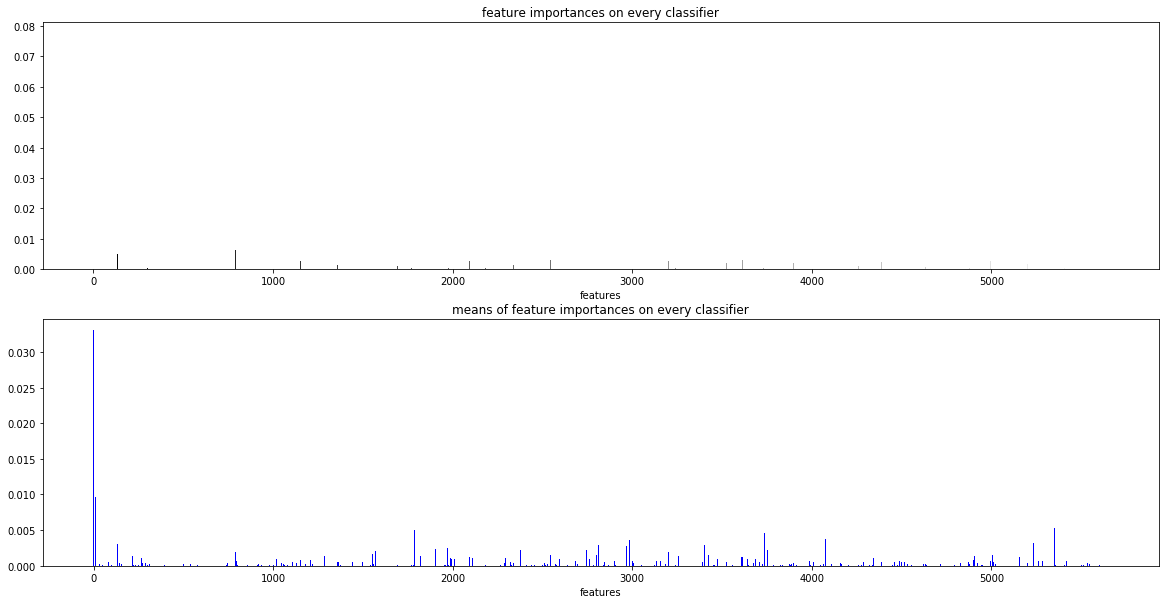

1
2
classifier : 1
f1_score : 0.9411764705882353
MCC :0.8554621848739495

classifier : 2
f1_score : 0.8669950738916257
MCC :0.6755658362473251

classifier : 3
f1_score : 0.7857142857142858
MCC :0.5052959915274424

classifier : 4
f1_score : 0.7572815533980582
MCC :0.3951635438605653

classifier : 5
f1_score : 0.7692307692307692
MCC :0.4171127573455804

classifier : 6
f1_score : 0.7289719626168223
MCC :0.2875779554002234

classifier : 7
f1_score : 0.7454545454545455
MCC :0.30659392477841835

classifier : 8
f1_score : 0.6697674418604652
MCC :0.12435777824185497

classifier : 9
f1_score : 0.6985645933014355
MCC :0.2330104935271803

3


NameError: name 'subplots_adjust' is not defined

<Figure size 720x720 with 0 Axes>

In [7]:
t1 = time.time()
#DataSets 1 tour = 2 players play
nbTurn=9 # nb last turn to be considered

listClassifier=trainClassifier('partiesHS/Datasets_GameOf9Turn/Datasets_train_1turn2plays',nbTurn)
print(1)
matrixProbaA,matrixProbaB,listClassifier_pred_y,listClassifier_test_y=testClassifier(listClassifier,'partiesHS/Datasets_GameOf9Turn/Datasets_test_1turn2plays',nbTurn)
print(2)
printScore(listClassifier_pred_y,listClassifier_test_y)
print(3)
plotProba(matrixProbaA,matrixProbaB)
print(4)
plotProbaMeans(matrixProbaA,matrixProbaB)

t2 = time.time() - t1
print (t2)

In [ ]:
#DataSets 1 turn = 1 player plays
#listClassifier=trainClassifier('partiesHS/Datasets_train')
#matrixProbaA,matrixProbaB,listClassifier_pred_y,listClassifier_test_y=testClassifier(listClassifier,'partiesHS/Datasets_test','partiesHS')
#printScore(listClassifier_pred_y,listClassifier_test_y)
#plotProbaMeans(matrixProbaA,matrixProbaB)